In [ ]:
#all important stuff to make sure code runs well
from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools
import random
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
random.seed(42)


In [ ]:
#loading the data set
data = pd.read_csv('cardio_train.csv', sep = ';')

In [ ]:
#check for null values
null_rows = data[data.isnull().any(axis=1)].head()
#print(null_rows.head()) #-->no null values

#check whether data set is balanced
sick = data['cardio'].value_counts()[1]
healthy = len(data) - data['cardio'].value_counts()[1]
#print("sick: ", sick, "individuals; healthy: ", healthy, "individuals")

data_target = data['cardio']
data['BMI'] = data['weight'] / (data['height'] / 100)**2
#convert age to years so we can interpret it better
data['age'] = data['age'] / 365
#check correlations of features to target value
numerdata = data.drop(columns=['gender', 'cholesterol', 'gluc',	'smoke',	'alco','active','BMI'])
print(numerdata.corr()['cardio'].sort_values(ascending=False))

#dropping the label column & id feature
data = data.drop(columns=['cardio', 'id','height'])


cardio    1.000000
age       0.238159
weight    0.181660
ap_lo     0.065719
ap_hi     0.054475
id        0.003799
height   -0.010821
Name: cardio, dtype: float64


In [ ]:
#one-hot encoding the categorical features & normalizing the numerical features
numerical_features = ['age', 'weight', 'ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc',	'smoke',	'alco','active']
full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
     ("cat", OneHotEncoder(), categorical_features)
    ])

data = full_pipeline.fit_transform(data)
categorical_feature_names = full_pipeline.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine numerical and categorical feature names
all_feature_names = numerical_features + list(categorical_feature_names)

# Create the DataFrame
transformed_df = pd.DataFrame(data, columns=all_feature_names)

data = transformed_df
print(data)

            age    weight     ap_hi     ap_lo  gender_1  gender_2  \
0     -0.436062 -0.847873 -0.122182 -0.088238       0.0       1.0   
1      0.307686  0.749831  0.072610 -0.035180       1.0       0.0   
2     -0.247997 -0.708942  0.007679 -0.141297       1.0       0.0   
3     -0.748152  0.541435  0.137541  0.017879       0.0       1.0   
4     -0.808543 -1.264666 -0.187113 -0.194356       1.0       0.0   
...         ...       ...       ...       ...       ...       ...   
69995 -0.092762  0.124642 -0.057251 -0.088238       0.0       1.0   
69996  1.269492  3.597913  0.072610 -0.035180       1.0       0.0   
69997 -0.163286  2.139139  0.332333 -0.035180       0.0       1.0   
69998  1.200589 -0.153219  0.040145 -0.088238       1.0       0.0   
69999  0.434144 -0.153219 -0.057251 -0.088238       1.0       0.0   

       cholesterol_1  cholesterol_2  cholesterol_3  gluc_1  gluc_2  gluc_3  \
0                1.0            0.0            0.0     1.0     0.0     0.0   
1              

In [ ]:
#splitting the data for training & testing
train, test, target, target_test = train_test_split(data, data_target, test_size = 0.2, random_state = 42)

In [ ]:
def plot_roc_curve(target, score):
    fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(target, score)
    plt.figure(1)
    plt.plot(fpr_log_reg, tpr_log_reg, color='orange', lw=1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    # Print the area under ROC, which is also called "AUC (Area Under the ROC curve)"
    aucroc = metrics.auc(fpr_log_reg, tpr_log_reg)
    print('\nAUC of ROC: ', aucroc)

def print_four_metrics(target, predicted):
    print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target, predicted)))
    print("%-12s %f" % ('Precision:', metrics.precision_score(target, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
    print("%-12s %f" % ('Recall:', metrics.recall_score(target, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))
    print("%-12s %f" % ('F1 Score:', metrics.f1_score(target, predicted, labels=None, pos_label=1, average='binary', sample_weight=None)))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold

In [ ]:
###k-fold
ktrain = train.to_numpy()
ktarget = target.to_numpy()
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
mlpfold = []
accuracies = []
fold_num=1
for train_index, val_index in kfold.split(ktrain):
    X_train_fold, X_val_fold = ktrain[train_index], ktrain[val_index]
    y_train_fold, y_val_fold = ktarget[train_index], ktarget[val_index]
    hidden_layer_architecture = (25,25)
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_architecture,
                        max_iter=100, alpha=1e-4,
                        solver='sgd', verbose=False, tol=1e-4, random_state=1,
                        activation='logistic',
                        learning_rate_init=.1)
    mlp.fit(X_train_fold, y_train_fold)
    mlpfold.append(mlp)
    pred = mlp.predict(X_val_fold)
    accuracy = metrics.accuracy_score(y_val_fold,pred)
    print(f"Validation accuracy for fold {fold_num}: {accuracy}")
    accuracies.append(accuracy)
    fold_num += 1
###find the highest one to be fold 2
mlp = mlpfold[1]
print_four_metrics(target_test, mlp.predict(test))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Validation accuracy for fold 1: 0.7251785714285715


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Validation accuracy for fold 2: 0.7316071428571429


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Validation accuracy for fold 3: 0.7248214285714286


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Validation accuracy for fold 4: 0.7196428571428571


Iteration 1, loss = 0.66618691
Iteration 2, loss = 0.62064976
Iteration 3, loss = 0.59541357
Iteration 4, loss = 0.58012855
Iteration 5, loss = 0.57300011
Iteration 6, loss = 0.57134018
Iteration 7, loss = 0.56875876
Iteration 8, loss = 0.56732322
Iteration 9, loss = 0.56589252
Iteration 10, loss = 0.56474923
Iteration 11, loss = 0.56380344
Iteration 12, loss = 0.56255246
Iteration 13, loss = 0.56076318
Iteration 14, loss = 0.55979637
Iteration 15, loss = 0.55819738
Iteration 16, loss = 0.55680141
Iteration 17, loss = 0.55559168
Iteration 18, loss = 0.55403524
Iteration 19, loss = 0.55313593
Iteration 20, loss = 0.55202026
Iteration 21, loss = 0.55110504
Iteration 22, loss = 0.55022502
Iteration 23, loss = 0.54930938
Iteration 24, loss = 0.54891290
Iteration 25, loss = 0.54794533
Iteration 26, loss = 0.54788496
Iteration 27, loss = 0.54688844
Iteration 28, loss = 0.54640358
Iteration 29, loss = 0.54622292
Iteration 30, loss = 0.54578832
Iteration 31, loss = 0.54564041
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



training score: 0.7348928571428571
test score: 0.7361428571428571
Accuracy:    0.736143
Precision:   0.739809
Recall:      0.729892
F1 Score:    0.734817


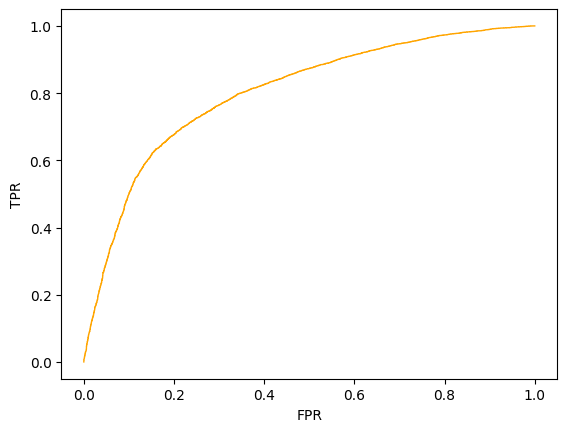


AUC of ROC:  0.8020482243866185


In [ ]:
###comparing multiple architecture
hidden_layer_architecture = (100,100)
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_architecture,
                    max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, tol=1e-4, random_state=1,
                    activation='logistic',
                    learning_rate_init=.1)
mlp.fit(train, target)
print('\ntraining score: {}'.format(mlp.score(train, target)))
print('test score: {}'.format(mlp.score(test, target_test)))
#pred=mlp.predict_proba(test)[:,1]
#print(pred)
#pred=mlp.predict(test)
#print(pred)
#cut_off->0.5
print_four_metrics(target_test, mlp.predict(test))
plot_roc_curve(target_test, mlp.predict_proba(test)[:,1])

In [ ]:
###the results
 (25,):
Accuracy:    0.737286
Precision:   0.767834
Recall:      0.681546
F1 Score:    0.722121
training score: 0.7333571428571428
test score: 0.7372857142857143
(25,25):
Accuracy:    0.739500
Precision:   0.770890
Recall:      0.682829
F1 Score:    0.724193
training score: 0.7353392857142858
test score: 0.7395
(25,25,25,25):
Accuracy:    0.737643
Precision:   0.763953
Recall:      0.689104
F1 Score:    0.724601
training score: 0.7353214285714286
test score: 0.7376428571428572
(5,5):
Accuracy:    0.738143
Precision:   0.757305
Recall:      0.702225
F1 Score:    0.728726
training score: 0.7343928571428572
test score: 0.7381428571428571
(100,100):
Accuracy:    0.736143
Precision:   0.739809
Recall:      0.729892
F1 Score:    0.734817
training score: 0.7348928571428571
test score: 0.7361428571428571